In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
data = pd.read_csv('train.csv')
data.head(4)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...


In [4]:
test = pd.read_csv('test.csv')

In [5]:
data['content'] = data.Title + ' ' + data.Description
labels = data["Class Index"]

In [6]:
test['content'] = test.Title + ' ' + test.Description
test_labels = test['Class Index']

In [7]:
train = data.copy()

In [8]:
train['Class Index'].unique()

array([3, 4, 2, 1])

In [9]:
train['Class Index'] = train['Class Index'].astype('str')

In [10]:
test['Class Index'] = test['Class Index'].astype('str')

In [11]:
for i in list(train['Class Index'].unique()):
    train[i] = train['Class Index'].apply(lambda x: 1 if i in x else 0)
    test[i] = test['Class Index'].apply(lambda x: 1 if i in x else 0)

In [12]:
train

,Class Index,Title,Description,content,3,4,2,1
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,1,0,0,0
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,1,0,0,0
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,1,0,0,0
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,1,0,0,0
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...",1,0,0,0
...,...,...,...,...,...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,Pakistan's Musharraf Says Won't Quit as Army C...,0,0,0,1
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,Renteria signing a top-shelf deal Red Sox gene...,0,0,1,0
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,Saban not going to Dolphins yet The Miami Dolp...,0,0,1,0
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,Today's NFL games PITTSBURGH at NY GIANTS Time...,0,0,1,0


In [13]:
train.drop(['Description', 'Title', 'Class Index'], axis=1, inplace=True)
test.drop(['Description', 'Title', 'Class Index'], axis=1, inplace=True)

In [14]:
train

,content,3,4,2,1
0,Wall St. Bears Claw Back Into the Black (Reute...,1,0,0,0
1,Carlyle Looks Toward Commercial Aerospace (Reu...,1,0,0,0
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,1,0,0,0
3,Iraq Halts Oil Exports from Main Southern Pipe...,1,0,0,0
4,"Oil prices soar to all-time record, posing new...",1,0,0,0
...,...,...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,0,0,1
119996,Renteria signing a top-shelf deal Red Sox gene...,0,0,1,0
119997,Saban not going to Dolphins yet The Miami Dolp...,0,0,1,0
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,0,0,1,0


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [ ]:
target_cols = [col for col in train.columns if col not in ['content']]
target_cols

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
        self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,4)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%1000 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Эксперимент 1

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Эксперимент 2

In [ ]:
# MAX_LEN = 200
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Эксперимент 3

In [ ]:
# MAX_LEN = 100
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Эксперимент 4

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 16
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Эксперимент 5

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Эксперимент 6

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 5
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Эксперимент 7

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 2
# LEARNING_RATE = 2e-6
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-6
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
def test():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

Эксперимент 1

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Эксперимент 2

In [ ]:
# MAX_LEN = 200
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Эксперимент 3

In [ ]:
# MAX_LEN = 100
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Эксперимент 4

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 16
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Эксперимент 5

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Эксперимент 6

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 5
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Эксперимент 7

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 2
# LEARNING_RATE = 2e-6
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-6
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
new_targets = []
for each in targets:
  tar = []
  tar.append(int(each[0] * 3))
  tar.append(int(each[1] * 4))
  tar.append(int(each[2] * 2))
  tar.append(int(each[3] * 1))
  new_targets.append(max(tar))

In [ ]:
# tar = []
# tar.append(int(targets[0][0] * 3))
# tar.append(int(targets[0][1] * 4))
# tar.append(int(targets[0][2] * 2))
# tar.append(int(targets[0][3] * 1))
# max(tar)

In [ ]:
cols = [3, 4, 2, 1]
new_outputs = []
count = 0
for each in outputs:
  count += 1
  if (not each[0] and not each[1] and  not each[2] and  not each[3]):
    i = random.randrange(len(cols))
    new_outputs.append(cols[i])
    continue 
  for i in range(4):
    if(each[i]):
      new_outputs.append(cols[i])
      break

Эксперимент 1

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 2

In [ ]:
# MAX_LEN = 200
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 3

In [ ]:
# MAX_LEN = 100
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 4

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 16
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 5

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 6

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 5
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 7

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 2
# LEARNING_RATE = 2e-6
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-6
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

In [ ]:
def saveModel():
    path = "./Roberta_AG_128_5_64_2e-5.pth"
    torch.save(model.state_dict(), path)

In [ ]:
saveModel()

Final

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
def test_model_by_train():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
train_outputs, train_targets = test_model_by_train()
train_outputs = np.array(train_outputs) >= 0.5
accuracy = metrics.accuracy_score(train_targets, train_outputs)
f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
train_outputs, train_targets = test_model_by_train()

In [ ]:
new_targets = []
for each in train_targets:
  tar = []
  tar.append(int(each[0] * 3))
  tar.append(int(each[1] * 4))
  tar.append(int(each[2] * 2))
  tar.append(int(each[3] * 1))
  new_targets.append(max(tar))

In [ ]:
test_outputs, test_targets = test()

In [ ]:
test_labels = []
for each in test_targets:
  tar = []
  tar.append(int(each[0] * 3))
  tar.append(int(each[1] * 4))
  tar.append(int(each[2] * 2))
  tar.append(int(each[3] * 1))
  test_labels.append(max(tar))

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC(C=0.1, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)
y_pred = clf.predict(test_outputs)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_pred))

Final

In [27]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9426315789473684
F1 Score (Micro) = 0.9453155883515615
F1 Score (Macro) = 0.945260007692192


In [28]:
def test_model_by_train():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [29]:
train_outputs, train_targets = test_model_by_train()
train_outputs = np.array(train_outputs) >= 0.5
accuracy = metrics.accuracy_score(train_targets, train_outputs)
f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9715916666666666
F1 Score (Micro) = 0.9732635934397784
F1 Score (Macro) = 0.9732759554816713


In [30]:
train_outputs, train_targets = test_model_by_train()

In [33]:
new_targets = []
for each in train_targets:
  tar = []
  tar.append(int(each[0] * 3))
  tar.append(int(each[1] * 4))
  tar.append(int(each[2] * 2))
  tar.append(int(each[3] * 1))
  new_targets.append(max(tar))

In [34]:
test_outputs, test_targets = test()

In [35]:
test_labels = []
for each in test_targets:
  tar = []
  tar.append(int(each[0] * 3))
  tar.append(int(each[1] * 4))
  tar.append(int(each[2] * 2))
  tar.append(int(each[3] * 1))
  test_labels.append(max(tar))

In [37]:
from sklearn.svm import LinearSVC

In [42]:
clf = LinearSVC(C=0.1, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)
y_pred = clf.predict(test_outputs)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9478947368421052
F1 Score (Micro) = 0.9478947368421052
F1 Score (Macro) = 0.947874903055829


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

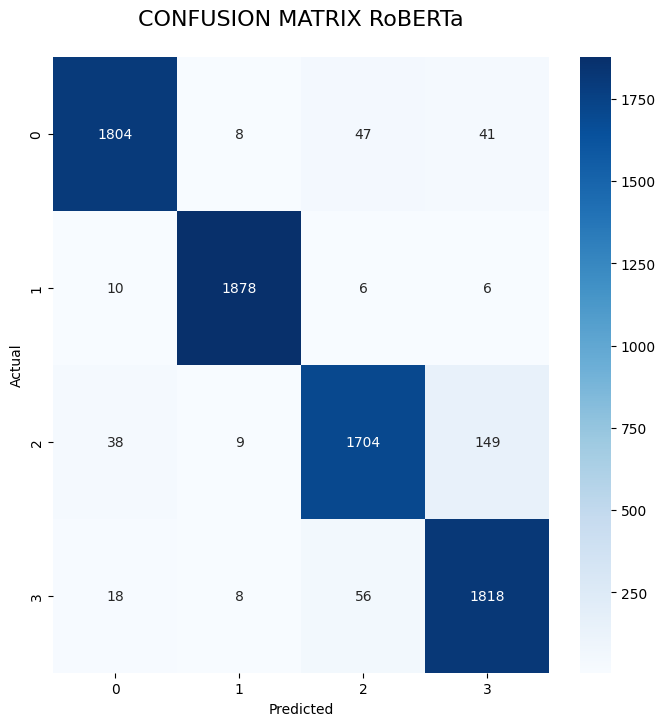

In [43]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

In [44]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           1       0.96      0.95      0.96      1900
           2       0.99      0.99      0.99      1900
           3       0.94      0.90      0.92      1900
           4       0.90      0.96      0.93      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600

